<a href="https://colab.research.google.com/github/gibsonx/CE888/blob/master/Assignment/sentiment_analysis_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U tensorflow tensorflow_datasets tensorflow_text zhon bert-for-tf2 sentencepiece

In [303]:
from google.colab import output
from google.colab import drive

import bert
import collections
import pathlib
import re
import string
import os
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem import WordNetLemmatizer
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow_datasets as tfds
import tensorflow_text as text

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from zhon import hanzi 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import csv

try:
    %tensorflow_version 2.x
except Exception:
    pass

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [159]:
drive.mount('/content/drive/')
base_dir = '/content/drive/MyDrive/tweeteval/datasets/'
hate_dir = base_dir + "hate"
irony_dir = base_dir + "irony"


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/tweeteval/datasets/hate


In [272]:
stop_words = set(stopwords.words('english'))

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', string)

def preprocess_tweet_text(tweet):
    tweet = tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = tweet.translate(str.maketrans('', '', hanzi.punctuation))
    tweet = remove_emoji(tweet)
    tweet_tokens = word_tokenize(tweet)
    # Remove stopwords
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    return " ".join(filtered_words)

def readfile(text):
  pd_list = []
  with open(text,'r') as f:
    for tweet in f.read().splitlines():
      pd_list.append(tweet)   
  return pd_list


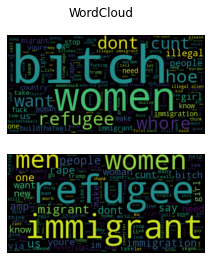

In [298]:
hate_dict = {'text': readfile(os.path.join(hate_dir,"train_text.txt")),
    'label': readfile(os.path.join(hate_dir,"train_labels.txt"))}
df_hate = pd.DataFrame(hate)
negative = df_hate[df_hate['label'] == '1']
positive = df_hate[df_hate['label'] == '0']
text_negative = " ".join(preprocess_tweet_text(review) for review in negative["text"])
text_positive = " ".join(preprocess_tweet_text(review) for review in positive["text"])
wordcloud_n = WordCloud().generate(text_negative)
wordcloud_p = WordCloud().generate(text_positive)
# plt.figure(figsize=(10,10))   


fig, (ax1, ax2) = plt.subplots(2,1)
fig.suptitle('WordCloud')
ax1.axis('off')
ax1.imshow(wordcloud_n, interpolation='bilinear')
ax2.axis('off')
ax2.imshow(wordcloud_p, interpolation='bilinear')
# plt.imshow(wordcloud, interpolation='bilinear')
plt.show()
plt.close()